# Project 3: More Classication

## Part 1: Acquire and Partition Data (5 points)

In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import math

# Set to 1 to standardize, 0 to not standardize
STD = 1

In [2]:
# Getting the Data via Python
data   = np.loadtxt('sonar5841.dat')
# Shuffle the data
np.random.shuffle(data)
data_x = data[:,0:-1]
data_y = data[:,-1]
print('shape of data_x:',data_x.shape)
print('shape of data_y',data_y.shape)

shape of data_x: (208, 60)
shape of data_y (208,)


In [3]:
# X data represent the energy over 60 bands ranging from 0 to 1
# Y data represent the classes, either rock or metal detected
#
# There are 111 metal and 97 rock
# http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

# Partitioning the Data
test_data_x = data_x[0:41]
test_data_y = data_y[0:41]

train_data_x = data_x[41:-1]
train_data_y = data_y[41:-1]

# Standardizing
train_x_mean = np.mean(train_data_x,0)
train_x_std  = np.std(train_data_x,0)
train_x_mean, train_x_std

if STD:
    train_data_x = (train_data_x - train_x_mean)/train_x_std
    test_data_x = (test_data_x - train_x_mean)/train_x_std
    
# print(train_data_x[0])

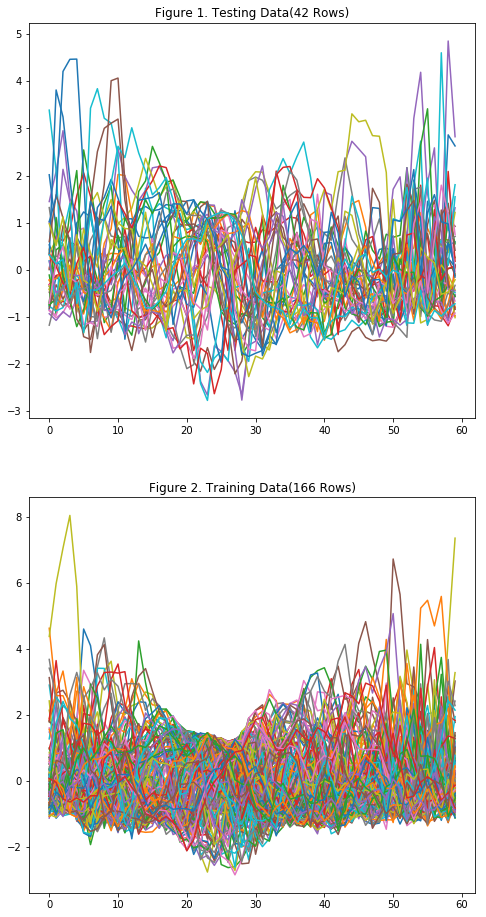

In [4]:
# Plotting
f1 = plt.figure(1, figsize=(8,16))
f1.clf()
test_data_plot  = f1.add_subplot(211)
test_data_plot.set_title("Figure 1. Testing Data(42 Rows)")
train_data_plot = f1.add_subplot(212)
train_data_plot.set_title("Figure 2. Training Data(166 Rows)")

for i in test_data_x:
    test_data_plot.plot(i)
for i in train_data_x:
    train_data_plot.plot(i)

# 2.1 Logistic Regression (5 points)

In [5]:
def IRLS(data_x, data_y):
    length        = len(data_x)
    not_converged = True
    w             = np.zeros(61)
    p             = np.empty(length)
    s             = np.empty(length)
    z             = np.empty(length)

#     ones          = np.ones(200)
#     ones[100:]    = ones[100:]*-1
    
#     temp_var      = np.hstack((ones[None].T,data_x))
#     np.random.shuffle(temp_var)
    
    y             = data_y
    data          = data_x
    print('Data shape is', data.shape, "data.T:",data.T.shape)
    
    i_count = 0
    while not_converged:
        
        w_prev = w
        for i in range(length):
            p[i] = np.exp(w_prev.dot(data[i])) / (1 + np.exp(w_prev.dot(data[i])))
            s[i] = p[i]*(1-p[i])          
#             if math.isnan(s[i]): s[i]=1
            z[i] = w_prev.dot(data[i]) + (y[i]-p[i])/(max(s[i],0.00001))
#         print("shape of z:", z.shape)
        diag_s = np.diag(s)
#         print("diag_s:",diag_s.shape)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
#         print("t1 shape", t1.shape)
        t2     = np.dot(np.dot(data.T, diag_s), z)
#         print("t1 and t2", t1.shape, t2.shape)
        # Here w should be (61,), t1(61,x), t2(x,1)
        w      = np.dot(t1, t2)
        w      = w/np.linalg.norm(w)
        
        i_count = i_count + 1
        print('Iterations',i_count)
        
        if abs(sum(w-w_prev)) < 0.000001:
            
            print("Converged!!")
            not_converged = False
            return w
            
        elif sum(abs(w)) > 900 or math.isnan(w[0]):
            
            print("Not converging!!!")
            return w
            
    return w

In [6]:
ones = np.ones(len(train_data_x))[None].T
train_data_x_1s = np.hstack((ones, train_data_x))

In [7]:
result = IRLS(train_data_x_1s, train_data_y)

Data shape is (166, 61) data.T: (61, 166)
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Converged!!


In [8]:
def LR_prob(w,x):
#     w = w[None].T
    term1 = np.exp(np.dot(x,w))
    term2 = 1 + np.exp(np.dot(x,w))
    prob  = term1/term2
    
    return prob

def LR_accuracy(x, y, result):
    ones = np.ones(len(x))[None].T
    x = np.hstack((ones, x))
    
    prob = LR_prob(result, x)
    # LR results
    LR_results = prob>0.5
    # Ground Truth
    OG_results = y>0
    # Comparing these 2 results
    acc = (sum(~np.logical_xor(LR_results,OG_results))-1)/(len(y)-1)
    
    return acc

In [9]:
LR_result = LR_accuracy(test_data_x, test_data_y, result)
print("Accuracy of Logistic regression: ", LR_result)

Accuracy of Logistic regression:  0.65


# 2.2 Linear SVMs (10 points)

In [10]:
from sklearn import svm
import operator

In [11]:
def data_partition(data_x, data_y, n):
    # combining x and y
    data = np.hstack((data_x,data_y[None].T))
    # shuffling data
    np.random.shuffle(data)
    # deviding data into 5 parts
    batch_size = int(len(data_y)/n) + 1 # +1 so we won't have a batch with 1 element in the end
#     print("Total length is", len(data_y), "batch size is",batch_size)
    data_p = []
    for i in range(n):

        end = i*batch_size+batch_size
#         print(i)
        if end < len(data_y):
            data_p.append(data[i*batch_size:end])
#             print("start",i*batch_size, "end", end)
        else:
            data_p.append(data[i*batch_size:end])
#             print("start",i*batch_size, "end --", )
#     print(data_p[-1].shape)
    data_p_x = []
    data_p_y = []
    for i in range(len(data_p)):
        
        data_p_x.append(data_p[i][:,0:-1])
        data_p_y.append(data_p[i][:,-1])
    
    return np.array(data_p_x), np.array(data_p_y)

def cross_validation(data_x, data_y, n, kernel, c):
    
    # partition data
    x,y = data_partition(data_x, data_y, n)
    # generating bollean mask
    bool_mask = np.diag(np.ones(n))
    bool_mask = (1 - bool_mask) > 0
    acc = []
    # extract each fold using boolean mask
    for i in range(n):
        xtrain = np.concatenate(x[bool_mask[i]])
        ytrain = np.concatenate(y[bool_mask[i]])
        xtest = np.concatenate(x[~bool_mask[i]])
        ytest = np.concatenate(y[~bool_mask[i]])
        if (kernel == 'linear'):
            svm_model = svm.LinearSVC(max_iter=5000, C=c)
        elif (kernel == 'kernel'):
            svm_model = svm.SVC(gamma=c, max_iter=5000)
            
        svm_model.fit(xtrain, ytrain)
        acc.append(svm_model.score(xtest, ytest))
    
#     print(acc)
    return np.mean(acc)

In [12]:
# iterate some Cs
x = []
c_vector = np.linspace(0.001,15,50)
for i in c_vector:
    x.append(cross_validation(train_data_x, train_data_y, 5, 'linear', i))
#     print(i)

c_index, max_x = max(enumerate(x), key=operator.itemgetter(1))
optimal_c = c_vector[c_index]

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


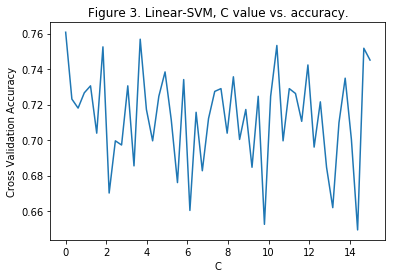

Maximun accuracy( 0.7607843137254903 ) occurs when C equals to 0.001


In [13]:
# ploting
fig2 = plt.figure(2)
plot2 = fig2.add_subplot(111)
plot2.set_title("Figure 3. Linear-SVM, C value vs. accuracy.")
plot2.plot(c_vector,x)
plot2.set_xlabel("C")
plot2.set_ylabel("Cross Validation Accuracy")
plt.show()
print("Maximun accuracy(",max_x,") occurs when C equals to", optimal_c)

In [14]:
# testing accuracy using optimal C value with testing data
optimal_linear_svm = svm.LinearSVC(max_iter=5000, C=optimal_c)
optimal_linear_svm.fit(train_data_x, train_data_y)
optimal_c_acc = optimal_linear_svm.score(test_data_x, test_data_y)
print("The accuracy of Linear SVM with optimal C is",optimal_c_acc)

The accuracy of Linear SVM with optimal C is 0.7804878048780488


In [15]:
# index, value = max(enumerate(x), key=operator.itemgetter(1))

In [16]:
# test = np.array([12,3,2,1,4,53,4,5,6])

In [17]:
# gettor = operator.itemgetter(0)
# gettor(test)

# 2.3 Kernel SVM (10 points)

In [18]:
# iterating Gamma
gamma_vector = np.linspace(0.0001,5,50)
kernelSVM_acc = []
for gamma in gamma_vector:
    kernelSVM_acc.append(cross_validation(train_data_x, train_data_y, 5, 'kernel', gamma))

g_index, max_gamma = max(enumerate(kernelSVM_acc), key=operator.itemgetter(1))
optimal_g = gamma_vector[g_index]
print("Maximun accuracy(",max_gamma,") occurs when Gamma equals to", optimal_g)

Maximun accuracy( 0.7137254901960784 ) occurs when Gamma equals to 0.10213877551020409


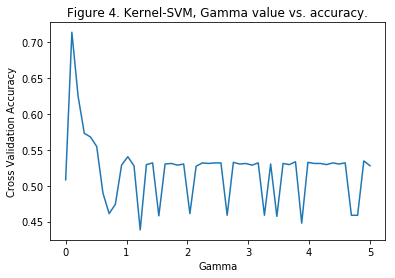

In [19]:
fig3 = plt.figure(3)
plot3 = fig3.add_subplot(111)
plot3.set_title("Figure 4. Kernel-SVM, Gamma value vs. accuracy.")
plot3.plot(gamma_vector,kernelSVM_acc)
plot3.set_xlabel("Gamma")
plot3.set_ylabel("Cross Validation Accuracy")
plt.show()

In [20]:
# testing accuracy using optimal Gamma with testing data
optimal_kernel_svm = svm.SVC(gamma=optimal_g, max_iter=5000)
optimal_kernel_svm.fit(train_data_x, train_data_y)
optimal_g_acc = optimal_kernel_svm.score(test_data_x, test_data_y)
print("The accuracy of Kernel SVM with optimal gamma is",optimal_g_acc)

The accuracy of Kernel SVM with optimal gamma is 0.7804878048780488


In [21]:
from tabulate import tabulate

In [22]:
# printing table
first_row = ['Value', optimal_c, optimal_g]
second_row = ['CV_Accuracy', max_x, max_gamma]
third_row = ['Test_Accuracy', optimal_c_acc, optimal_g_acc]
header = ['', 'Linear_SVM(C)', 'Kernel_SVM(Gamma)']
print(tabulate([first_row, second_row, third_row], headers=header))

                 Linear_SVM(C)    Kernel_SVM(Gamma)
-------------  ---------------  -------------------
Value                 0.001                0.102139
CV_Accuracy           0.760784             0.713725
Test_Accuracy         0.780488             0.780488


In [23]:
# printing conclusion
answer = ''
answer_list = ["Linear SVM", "Kernel SVM"]
if optimal_c_acc>optimal_g_acc:
    answer = answer_list[0]
else:
    answer = answer_list[1]
    
print("Base on the testing accuracy using optimal parameters, the best classifier for these data is\n\n-", answer)

Base on the testing accuracy using optimal parameters, the best classifier for these data is

- Kernel SVM
